## Intro 

This notebook is used as an example for testing a classification algorithm and applying it on real Respeck data, then outputting it into a standard format. We use an example model - a simple binary classifier - and a sample of real world data. Please use the same structure of functions to perform similar classification on AirSpeck data.

We want to be able to apply these models out of the box on any real time data we receive from our studies. 

Your model(s) should be applied in a simple function and produce a standardised result. 

## TODOs
Look out for the #TODOs to see where you should be writing your own code. Make sure you leave relevant comments and submit clean code. In the handover you will be asked to run this notebook on our call and explain what each function does. 

#### Imports

In [5]:
import os
import pandas as pd 
import numpy as np
from tqdm import tqdm
import multiprocessing
from multiprocessing import Value
from functools import partial
from sklearn.decomposition import PCA
from scipy.signal import medfilt
import matplotlib.pyplot as plt
window_id = Value('i', 0)
window_id_seq = 0

from typing import Tuple, List, Union, Optional

# TODO add any imports needed for your classifier here
from tensorflow.keras.models import load_model, Sequential
import pickle
import data_process as dp
#import pywt
import time

#### Helper functions and constants

You can now modify the below functions with the code for loading and applying your own models.

#### Classification parameters

Each classifier will have a set of parameters, for example window size, step size, any additional columns that must be generated during training or testing etc. 

Please list them all in the following classification parameters dictionary and use it throughout the rest of the functions.

#### Labels
Your classifier will output class labels - [0, 1, 2, ...]. Please provide a labels dictionary to map between a class number and what it represents.

### Loading the models

Please provide a loading function for each of your best models. If you are handing over multiple models, please write a separate loading function for each of them.

In [6]:
model_name = './models/xudong/example_model/in_out_classification_model.sav'
in_out_loaded_model = pickle.load(open(model_name,'rb'))

In [7]:
in_out_loaded_model

GradientBoostingClassifier(learning_rate=0.01, n_estimators=3000)

In [8]:
def load_model(model_path):
    loaded_model = pickle.load(open(model_path,'rb'))
    return loaded_model

### Preprocessing real-time data

Your models will be applied on real patient data coming from studies all around the world. An example of this file is provided in the top-level folder. 

Load this file and apply any pre-processing necessary for your model to run reliably. 

#### Example file

You can assume that the data is continuous, there are no gaps and the frequency is constant between the samples.

#### Generating new columns
Depending on which additional features you are using for your model, you will need to generate them if they are not present in the raw data file. For example, you can generate the eucledian norm of the accelerometer before even splitting the data into sliding windows, because the EN is only dependent on the current accel axis. 

However, if you are using more complex features such as smoothed out accelerometer, it's better to apply these functions on individual windows, since this is how we would analyse the data in real time. In this case you can add relevant code in the window splitting functions provided.

#### Example data

This is what the example data looks like. You can assume that your classifier will always be applied on data that has the exact same structure.

In [9]:
data_airspeck = pd.read_csv("./data/in_out/asthma_raw/INH007(1)_airspeck_personal_manual_raw.csv")
data_airspeck.timestamp = pd.to_datetime(data_airspeck.timestamp)
data_airspeck.index = data_airspeck.timestamp
# data_airspeck.drop(columns=['timestamp'], inplace=True)

data_airspeck

,timestamp,pm1,pm2_5,pm10,temperature,humidity,bin0,bin1,bin2,bin3,...,bin14,bin15,total,gpsLongitude,gpsLatitude,gpsAltitude,gpsAccuracy,luxLevel,motion,battery
timestamp,,,,,,,,,,,,,,,,,,,,,
2022-01-13 18:44:48.372,2022-01-13 18:44:48.372,0.000000,0.000000,0.000000,20.800001,35.800000,0,0,0,0,...,0,0,0,-0.210217,51.495004,51.800003,11.251,0,0,188
2022-01-13 18:45:14.814,2022-01-13 18:45:14.814,17.519646,37.952890,121.080780,21.100000,33.700000,1352,677,105,31,...,0,3,2197,-0.210217,51.495007,51.900002,7.558,0,0,173
2022-01-13 18:45:44.459,2022-01-13 18:45:44.459,11.856957,25.740059,74.875020,21.800001,32.500000,1570,813,106,37,...,1,1,2567,-0.210217,51.495007,51.900002,7.293,0,0,178
2022-01-13 18:46:15.413,2022-01-13 18:46:15.413,8.303588,17.407263,31.142834,22.300001,31.600000,1723,670,114,29,...,0,0,2565,-0.210217,51.495007,61.600002,5.716,0,0,245
2022-01-13 18:46:45.104,2022-01-13 18:46:45.104,6.622044,13.094225,42.310710,22.600000,30.900000,1847,477,99,22,...,0,3,2470,-0.210217,51.495007,58.300003,7.102,0,0,107
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-28 06:40:55.455,2022-01-28 06:40:55.455,0.016335,0.017400,0.017400,29.700000,20.800001,10,0,0,0,...,0,0,10,-0.171907,51.490907,56.500000,4.468,0,0,83
2022-01-28 06:41:34.794,2022-01-28 06:41:34.794,0.011367,0.015076,0.015163,29.700000,20.900000,4,1,0,0,...,0,0,5,-0.171932,51.490907,56.500000,5.512,0,0,46
2022-01-28 06:42:13.495,2022-01-28 06:42:13.495,0.011322,0.012060,0.012060,29.700000,21.100000,7,0,0,0,...,0,0,7,-0.172038,51.490922,56.500000,5.678,0,0,96


In [32]:
def read_airspeck_data (data_path):
    data_airspeck = pd.read_csv(data_path)
    data_airspeck.timestamp = pd.to_datetime(data_airspeck.timestamp)
    data_airspeck.index = data_airspeck.timestamp
    return data_airspeck

In [10]:
def classify_in_out_airspeck_data(data, model,subject_id = None,map = None):

    # Select the columns your model is interested in
    start = time.clock()
    cols_of_interest = ['pm2_5']
    cols_of_interest += ['temperature', 'humidity']
    cols_of_interest += ['bin0','bin1', 'bin2', 'bin3', 'bin4', 'bin5', 'bin6', 'bin7', 'bin8', 'bin9','bin10', 'bin11', 'bin12', 'bin13', 'bin14', 'bin15']
    cols_of_interest = sorted(list(set(cols_of_interest)))

    # import london osm map for unseen airspeck data and home/work office gps location,
    # you need to download city's geojson file and save it in ./data/geojson/'map'/, in here, we use london('toby_new' folder) as an example
    london_road = dp.load_highway(map)
    london_land = dp.load_landuse(map)
    # you may want to change the gps location for your own data, if you don't have the gps location,
    # if you don't have the subject home / office gps location, you may want to delete this part
    home_work_gps = pd.read_csv('./data/in_out/subject_home_gps.csv') # this is home and work gps location for each INHALE subject

    # load osm feature
    data_osm = dp.add_road_feature(london_road, data)
    data_osm = dp.add_land_feature(london_land, data_osm)
    data_osm = dp.distance_euclidean(data_osm)
    data_osm = dp.calculate_std(data_osm, 'gps_dist', k=10)

    #encode osm feature
    data_osm['highway'] = data_osm['highway'].astype('category')
    data_osm['highway_encode'] = data_osm['highway'].cat.codes
    data_osm['landuse'] = data_osm['landuse'].astype('category')
    data_osm['landuse_encode'] = data_osm['landuse'].cat.codes
    
    relevant_data = data_osm[cols_of_interest + ['gps_dist','highway_encode', 'distance', 'landuse_encode','gps_dist_std']]

    # Now we have a test dataset which we can apply the model on
    predictions = model.predict(relevant_data)
    data_osm['i/o'] = predictions
   
    # keep required columns
    Required_columns = ['timestamp','pm1','pm2_5','pm10','gpsLongitude','gpsLatitude','gpsAltitude','i/o']
    
    # add home and work gps location for each subject if you have the gps location, if not, you may want to delete this part
    try:
    #load subject home/ office position
        subject_filter = home_work_gps.loc[home_work_gps['Subject ID'] == subject_id]
        home_lat = subject_filter['Home GPS latitude'].to_numpy()
        home_long = subject_filter['Home GPS longitude'].to_numpy()
        work_lat = subject_filter['Work GPS latitude' ].to_numpy()
        work_long = subject_filter['Work GPS longitude'].to_numpy()
    
    # calculate the distance between each datapoint and home
        data_filter = dp.distance_euclidean_home(data_osm,home_long,home_lat)
    # calculate the distance between each datapoint and work office
        data_filter = dp.distance_euclidean_work(data_filter,work_long,work_lat)

    # filter the point close to home and office
        data_filter.loc[data_filter['home_dist'] < 0.0005, 'i/o'] = 0

        data_filter.loc[data_filter['work_dist'] < 0.0005, 'i/o'] = 0

        data_filter.sort_values(by = 'timestamp')
    except:
        data_filter = data_osm
    
    patient_filted = data_filter[Required_columns] # keep required columns
    end = time.clock()
    print('Running time: %s Seconds' % (end - start))
    return  patient_filted

In [11]:
test_result = classify_in_out_airspeck_data(data_airspeck, in_out_loaded_model,subject_id = 'INH007(1)',map = 'toby_new')

Running time: 284.253745 Seconds


# predict inhale data using one function

In [10]:
filePath = './data/in_out/airspeck_raw_update'
patient_filename = os.listdir(filePath)
if('.DS_Store' in patient_filename):
    patient_filename.remove('.DS_Store')
patient_filename.sort()

In [11]:
patient_filename

['INH001(1)_airspeck_personal_manual_raw.csv',
 'INH001(2)_airspeck_personal_manual_raw.csv',
 'INH002(1)_airspeck_personal_manual_raw.csv',
 'INH002(2)_airspeck_personal_manual_raw.csv',
 'INH003(1)_airspeck_personal_manual_raw.csv',
 'INH003(2)_airspeck_personal_manual_raw.csv',
 'INH004(1)_airspeck_personal_manual_raw.csv',
 'INH004(2)_airspeck_personal_manual_raw.csv',
 'INH005(1)_airspeck_personal_manual_raw.csv',
 'INH005(2)_airspeck_personal_manual_raw.csv',
 'INH006(1)_airspeck_personal_manual_raw.csv',
 'INH006(2)_airspeck_personal_manual_raw.csv',
 'INH007(1)_airspeck_personal_manual_raw.csv',
 'INH008(1)_airspeck_personal_manual_raw.csv',
 'INH011(1)_airspeck_personal_manual_raw.csv',
 'INH014(1)_airspeck_personal_manual_raw.csv',
 'INH100(1)_airspeck_personal_manual_raw.csv',
 'INH100(2)_airspeck_personal_manual_raw.csv',
 'INH101(1)_airspeck_personal_manual_raw.csv',
 'INH101(2)_airspeck_personal_manual_raw.csv',
 'INH102(1)_airspeck_personal_manual_raw.csv',
 'INH102(2)_a

generate inhale update data (in_out)

In [29]:
def predict_asthma(patient_type,model):
    filePath = './data/in_out/' + patient_type
    patient_filename = os.listdir(filePath)
    if('.DS_Store' in patient_filename):
        patient_filename.remove('.DS_Store')
    patient_filename.sort()
    home_work_gps = pd.read_csv('./data/in_out/subject_home_gps.csv')
    home_work_gps = home_work_gps.fillna(0)

    chosen_columns_osm = ['pm1', 'pm2_5', 'pm10','temperature', 'humidity','bin0','bin1', 'bin2', 'bin3', 'bin4', 'bin5', 'bin6', 'bin7', 'bin8', 'bin9','bin10', 'bin11', 'bin12', 'bin13', 'bin14', 'bin15', 'gps_dist','highway_encode', 'distance', 'landuse_encode','gps_dist_std']
    Required_columns = ['timestamp','pm1','pm2_5','pm10','gpsLongitude','gpsLatitude','gpsAltitude','i/o']
    

    cols_of_interest = ['pm1', 'pm2_5', 'pm10']
    cols_of_interest += ['temperature', 'humidity']
    cols_of_interest += ['bin0','bin1', 'bin2', 'bin3', 'bin4', 'bin5', 'bin6', 'bin7', 'bin8', 'bin9','bin10', 'bin11', 'bin12', 'bin13', 'bin14', 'bin15']
    cols_of_interest = sorted(list(set(cols_of_interest)))
    # import london osm map for unseen airspeck data and home/work office gps location
    london_road = dp.load_highway('toby_new')
    london_land = dp.load_landuse('toby_new')
    home_work_gps = pd.read_csv('./data/in_out/subject_home_gps.csv') 

    print('###########step 1 finish###########')

    for i in range(len(patient_filename)): 
        patient_data = pd.read_csv('./data/in_out/' + patient_type + '/' + patient_filename[i])
        #load osm data
        patient_osm = dp.add_road_feature(london_road, patient_data)
        patient_osm = dp.add_land_feature(london_land, patient_osm)
        patient_osm = dp.distance_euclidean(patient_osm)
        patient_osm = dp.calculate_std(patient_osm, 'gps_dist', k=10)
        # encode
        patient_osm['highway'] = patient_osm['highway'].astype('category')
        patient_osm['highway_encode'] = patient_osm['highway'].cat.codes
        patient_osm['landuse'] = patient_osm['landuse'].astype('category')
        patient_osm['landuse_encode'] = patient_osm['landuse'].cat.codes

        relevant_data = patient_osm[cols_of_interest + ['gps_dist','highway_encode', 'distance', 'landuse_encode','gps_dist_std']]

        print(f"########## start predict {patient_filename[i]}###########")
        # predict data
        # test_x = patient_osm[chosen_columns_osm]

        test_pre = model.predict(relevant_data)
        patient_osm['i/o'] = test_pre
        
        print(f"########## finish predict {patient_filename[i]}###########")

        patient_id = patient_filename[i].split('_')[0]
        patient_filter = home_work_gps.loc[home_work_gps['Subject ID'] == patient_id]
        
        home_lat = patient_filter['Home GPS latitude'].to_numpy()
        home_long = patient_filter['Home GPS longitude'].to_numpy()
        work_lat = patient_filter['Work GPS latitude' ].to_numpy()
        work_long = patient_filter['Work GPS longitude'].to_numpy()
 
         

        patient_re = patient_osm[Required_columns]
        patient_home_filter = dp.distance_euclidean_home(patient_re,home_long,home_lat)
        patient_work_filter = dp.distance_euclidean_work(patient_home_filter,work_long,work_lat)

        
        patient_work_filter.loc[patient_work_filter['home_dist'] < 0.0005, 'i/o'] = 0
        
        patient_work_filter.loc[patient_work_filter['work_dist'] < 0.0005, 'i/o'] = 0 
        
        patient_work_filter.sort_values(by = 'timestamp')

        patient_filted = patient_work_filter[Required_columns] 

        print((f"########## done predict {patient_filename[i]}###########"))

        patient_filted.to_csv('./data/inhale_inout_predict/' + patient_filename[i].split('_')[0] + 'inout_predict_update.csv')

    
        
    

In [39]:
predict_asthma(patient_type = 'airspeck_raw_update',model = in_out_loaded_model)

###########step 1 finish###########
########## start predict INH001(1)_airspeck_personal_manual_raw.csv###########
########## finish predict INH001(1)_airspeck_personal_manual_raw.csv###########
########## done predict INH001(1)_airspeck_personal_manual_raw.csv###########
########## start predict INH001(2)_airspeck_personal_manual_raw.csv###########
########## finish predict INH001(2)_airspeck_personal_manual_raw.csv###########
########## done predict INH001(2)_airspeck_personal_manual_raw.csv###########
########## start predict INH002(1)_airspeck_personal_manual_raw.csv###########
########## finish predict INH002(1)_airspeck_personal_manual_raw.csv###########


KeyboardInterrupt: 

In [34]:
classified_data = classify_in_out_airspeck_data(data=data_airspeck, model=in_out_loaded_model)

Running time: 470.16114300000015 Seconds


In [35]:
classified_data

,timestamp,pm1,pm2_5,pm10,temperature,humidity,bin0,bin1,bin2,bin3,...,distance,close_road_idx,landuse,close_land_idx,gps_dist,gps_dist_std,highway_encode,landuse_encode,i/o,home_dist
2022-01-13 18:44:48.372,2022-01-13 18:44:48.372,0.000000,0.000000,0.000000,20.800001,35.800000,0,0,0,0,...,0.000021,56626.0,unknown,NaN,0.000000,0.000000,2,3,1,0
2022-01-13 18:45:14.814,2022-01-13 18:45:14.814,17.519646,37.952890,121.080780,21.100000,33.700000,1352,677,105,31,...,0.000023,56626.0,unknown,NaN,0.000003,0.000000,2,3,1,0
2022-01-13 18:45:44.459,2022-01-13 18:45:44.459,11.856957,25.740059,74.875020,21.800001,32.500000,1570,813,106,37,...,0.000023,56626.0,unknown,NaN,0.000000,0.000000,2,3,1,0
2022-01-13 18:46:15.413,2022-01-13 18:46:15.413,8.303588,17.407263,31.142834,22.300001,31.600000,1723,670,114,29,...,0.000023,56626.0,unknown,NaN,0.000000,0.000000,2,3,1,0
2022-01-13 18:46:45.104,2022-01-13 18:46:45.104,6.622044,13.094225,42.310710,22.600000,30.900000,1847,477,99,22,...,0.000023,56626.0,unknown,NaN,0.000000,0.000000,2,3,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-28 06:40:55.455,2022-01-28 06:40:55.455,0.016335,0.017400,0.017400,29.700000,20.800001,10,0,0,0,...,0.000001,53153.0,residential,370656.0,0.000015,0.000391,2,2,1,0
2022-01-28 06:41:34.794,2022-01-28 06:41:34.794,0.011367,0.015076,0.015163,29.700000,20.900000,4,1,0,0,...,0.000015,53153.0,residential,370656.0,0.000025,0.000309,2,2,1,0
2022-01-28 06:42:13.495,2022-01-28 06:42:13.495,0.011322,0.012060,0.012060,29.700000,21.100000,7,0,0,0,...,0.000071,53153.0,residential,370656.0,0.000107,0.000147,2,2,1,0
2022-01-28 06:42:52.193,2022-01-28 06:42:52.193,0.001606,0.001710,0.001710,29.800001,21.200000,1,0,0,0,...,0.000032,53153.0,residential,370656.0,0.000073,0.000133,2,2,1,0


In our classified model, Indoor point will classified as 0, and Outdoor point will classified as 1

In [26]:
classified_data

(                                      timestamp        pm1      pm2_5  \
 2022-01-13 18:44:48.372 2022-01-13 18:44:48.372   0.000000   0.000000   
 2022-01-13 18:45:14.814 2022-01-13 18:45:14.814  17.519646  37.952890   
 2022-01-13 18:45:44.459 2022-01-13 18:45:44.459  11.856957  25.740059   
 2022-01-13 18:46:15.413 2022-01-13 18:46:15.413   8.303588  17.407263   
 2022-01-13 18:46:45.104 2022-01-13 18:46:45.104   6.622044  13.094225   
 ...                                         ...        ...        ...   
 2022-01-28 06:40:55.455 2022-01-28 06:40:55.455   0.016335   0.017400   
 2022-01-28 06:41:34.794 2022-01-28 06:41:34.794   0.011367   0.015076   
 2022-01-28 06:42:13.495 2022-01-28 06:42:13.495   0.011322   0.012060   
 2022-01-28 06:42:52.193 2022-01-28 06:42:52.193   0.001606   0.001710   
 2022-01-28 06:43:30.231 2022-01-28 06:43:30.231   0.003274   0.003487   
 
                                pm10  gpsLongitude  gpsLatitude  gpsAltitude  \
 2022-01-13 18:44:48.372    0.

In [75]:
def classify_transportation_airspeck_data(data: pd.DataFrame, model) -> pd.DataFrame:
    """
    Function for classifying preprocessed arispeck data, Uses an already trained model.
    :param data: The in/out classified airspeck DataFrame,.
    :param model: The trained model used for transportation classification.
    :returns: DataFrame with columns 'mode'.
    """
    # TODO modify this according to what your own model requires

    # Select the columns your model is interested in
    start = time.clock()
    cols_of_interest = ['pm1', 'pm2_5', 'pm10']
    cols_of_interest += ['temperature', 'humidity']
    cols_of_interest += ['bin0','bin1', 'bin2', 'bin3', 'bin4', 'bin5', 'bin6', 'bin7', 'bin8', 'bin9','bin10', 'bin11', 'bin12', 'bin13', 'bin14', 'bin15']
    cols_of_interest += ['gps_dist', 'gps_dist_std','highway_encode', 'landuse_encode']
    cols_of_interest = sorted(list(set(cols_of_interest)))

    #select outdoor datapoint in input data
    data = data.loc[data['i/o'] == 1]
    #import OSM station info
    station_info = dp.load_station('toby_new')
    
    #load osm station
    data_osm = dp.add_station_feature(station_info,data)

    # add time-features
    data_time = dp.add_time_feature_station(data_osm, t=19)

    # select data point between 6am to 8pm
    data_time = data_time.sort_values(by='timestamp')
    data_time['hour']= data_time['timestamp'].dt.hour
    data_time_selected = data_time.loc[(data_time['hour'] >= 6)]
    data_time_selected = data_time_selected.loc[(data_time_selected['hour']<= 20)]

    #
    relevant_data = data_time_selected[cols_of_interest + ['station_encode','station_distance',
          'avg_dist','same_land','same_road']]
    transport_prediction = model.predict(relevant_data)
    data_time_selected['mode'] = transport_prediction
    end = time.clock()
    print('Running time: %s Seconds' % (end - start))
    return data_time_selected

In transportation model, there are 6 transportation mode we classified: In the car, On the bus, On the train, On the tube, Riding a bike, Walking/Running


In [55]:
trans_mode_model_path = '/Users/zhangxudong/Desktop/project/xudong_forTeo/models/xudong/example_model/transportation_mode_classification_model.sav'
transport_model = load_model(trans_mode_model_path)

In [36]:
transport_classified_data = classify_transportation_airspeck_data(data= classified_data,model =transport_model)

KeyboardInterrupt: 

In [27]:
transport_classified_data

,timestamp,pm1,pm2_5,pm10,gpsLongitude,gpsLatitude,gpsAltitude,mode
2022-01-13 18:44:48.372,2022-01-13 18:44:48.372,0.000000,0.000000,0.000000,-0.210217,51.495004,51.800003,On the train
2022-01-13 18:45:14.814,2022-01-13 18:45:14.814,17.519646,37.952890,121.080780,-0.210217,51.495007,51.900002,On the bus
2022-01-13 18:45:44.459,2022-01-13 18:45:44.459,11.856957,25.740059,74.875020,-0.210217,51.495007,51.900002,On the train
2022-01-13 18:46:15.413,2022-01-13 18:46:15.413,8.303588,17.407263,31.142834,-0.210217,51.495007,61.600002,On the train
2022-01-13 18:46:45.104,2022-01-13 18:46:45.104,6.622044,13.094225,42.310710,-0.210217,51.495007,58.300003,On the train
...,...,...,...,...,...,...,...,...
2022-01-28 06:30:46.568,2022-01-28 06:30:46.568,0.027558,0.037090,0.037316,-0.182480,51.485112,54.900002,On the train
2022-01-28 06:31:18.187,2022-01-28 06:31:18.187,0.010059,0.010715,0.010715,-0.180780,51.486118,54.800003,Riding a bike
2022-01-28 06:31:50.413,2022-01-28 06:31:50.413,0.013930,0.014839,0.014839,-0.179365,51.486995,54.400002,On the train
2022-01-28 06:32:22.035,2022-01-28 06:32:22.035,0.018072,0.019251,0.019251,-0.177246,51.488329,54.400002,On the train


# Validation set of new log data XXXA151

In [56]:
new_logs = pd.read_csv('../xudongzhang/new_london_data_eda/all_data_xxxa151_twoid.csv')

In [109]:
from sklearn.metrics import confusion_matrix

# car journey

In [57]:
car_jour = new_logs.loc[new_logs['activity'] == 'In the car']

In [61]:
indoor_outdoor_classified_data = classify_in_out_airspeck_data(data = car_jour, model= in_out_loaded_model,subject_id = 'INH007(1)')

Running time: 300.36228200000005 Seconds


In [112]:
car_jour['location'] = 1

In [114]:
car_jour['location']

1050    1
1051    1
1052    1
1053    1
1054    1
       ..
4675    1
4676    1
4677    1
4678    1
4679    1
Name: location, Length: 1488, dtype: int64

In [63]:
np.unique(indoor_outdoor_classified_data['i/o'],return_counts =True)

(array([0, 1]), array([  24, 1476]))

In [117]:
indoor_outdoor_classified_data['location'] = 1

In [123]:
from sklearn.metrics import confusion_matrix

#Generate the confusion matrix
cf_matrix = confusion_matrix(indoor_outdoor_classified_data['location'],indoor_outdoor_classified_data['i/o'])

print(cf_matrix)

[[   0    0]
 [  24 1476]]


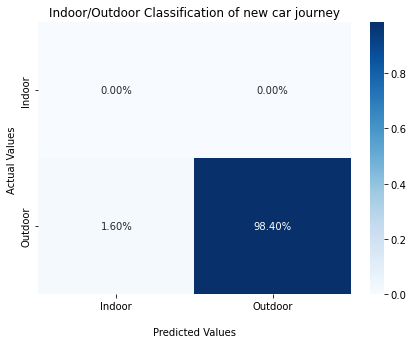

In [130]:
import seaborn as sns
fig = plt.figure(figsize = (7,5))
ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('Indoor/Outdoor Classification of new car journey');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Indoor','Outdoor'])
ax.yaxis.set_ticklabels(['Indoor','Outdoor'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [ ]:
plot_confusion_matrix

In [73]:
indoor_outdoor_classified_data['timestamp'] = pd.to_datetime(indoor_outdoor_classified_data['timestamp'], errors='coerce')

In [76]:
transport_classified_data = classify_transportation_airspeck_data(data= indoor_outdoor_classified_data,model =transport_model)

Running time: 69.52005999999983 Seconds


In [78]:
np.unique(transport_classified_data['mode'],return_counts =True)

(array(['In the car', 'On the bus', 'On the train', 'Riding a bike',
        'Walking/running'], dtype=object),
 array([  1, 466, 255, 607, 152]))

## bus journey

In [92]:
np.unique(new_logs['activity'])

array(['Background', 'Entrance to platform', 'In the car', 'On the bus',
       'On the platform', 'On the tube', 'Platform to entrance',
       'Riding a bike', 'Traffic', 'Walking'], dtype=object)

In [93]:
bus_jour = new_logs.loc[new_logs['activity'] == 'On the bus']

In [94]:
bus_jour

,Unnamed: 0,phoneTimestamp,pm1,pm2_5,pm10,temperature,humidity,bin0,bin1,bin2,...,activity,notes,location_type,activity_type,recording_id,activity_id,Unnamed: 0.1,Unnamed: 0.1.1,timestamp,day
400,400,1647331286393,3.065174,11.875157,76.544370,21.200000,47.500000,233.0,831.0,242.0,...,On the bus,waiting for bus,0.0,0.0,38,31,NaN,NaN,2022-03-15 08:01:26.393,15
401,401,1647331321216,4.263174,17.288397,72.663950,21.400000,50.700000,125.0,1286.0,380.0,...,On the bus,waiting for bus,0.0,0.0,38,31,NaN,NaN,2022-03-15 08:02:01.216,15
402,402,1647331355383,4.110686,15.244204,62.076500,21.800001,50.000000,329.0,1112.0,329.0,...,On the bus,waiting for bus,0.0,0.0,38,31,NaN,NaN,2022-03-15 08:02:35.383,15
403,403,1647331387010,4.422235,17.240559,59.795640,22.200000,49.200000,126.0,1213.0,348.0,...,On the bus,waiting for bus,0.0,0.0,38,31,NaN,NaN,2022-03-15 08:03:07.010,15
404,404,1647331417969,4.500042,16.747840,58.890095,22.600000,49.100002,33.0,1229.0,370.0,...,On the bus,waiting for bus,0.0,0.0,38,31,NaN,NaN,2022-03-15 08:03:37.969,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4156,4156,1647853673075,1.691374,5.015460,28.854763,21.800001,36.200000,206.0,665.0,57.0,...,On the bus,NaN,0.0,0.0,83,58,2595.0,1034.0,2022-03-21 09:07:53.075,21
4157,4157,1647853706597,11.578173,31.534184,115.270100,21.800001,36.600002,452.0,4927.0,415.0,...,On the bus,NaN,0.0,0.0,83,58,2596.0,1035.0,2022-03-21 09:08:26.597,21
4158,4158,1647853740765,10.464081,25.331507,83.106440,21.900000,36.800000,980.0,4285.0,333.0,...,On the bus,NaN,0.0,0.0,83,58,2597.0,1036.0,2022-03-21 09:09:00.765,21
4159,4159,1647853773724,9.391085,25.556332,152.392230,22.000000,38.500000,1214.0,3546.0,324.0,...,On the bus,NaN,0.0,0.0,83,58,2598.0,1037.0,2022-03-21 09:09:33.724,21


In [95]:
indoor_outdoor_classified_data2 = classify_in_out_airspeck_data(data = bus_jour, model= in_out_loaded_model)

aaaaa
bbbbb
Running time: 290.0175360000003 Seconds


In [96]:
np.unique(indoor_outdoor_classified_data2['i/o'],return_counts =True)

(array([1]), array([1635]))

In [131]:
indoor_outdoor_classified_data2['location'] = 1

In [136]:
confusion_matrix(indoor_outdoor_classified_data2['location'],indoor_outdoor_classified_data2['i/o'])


array([[1635]])

In [138]:
confusion_matrix(indoor_outdoor_classified_data2['location'],indoor_outdoor_classified_data2['i/o'])

array([[1635]])

In [146]:
cf_matrix = ([[  0,   0],
       [ 0, 100]])

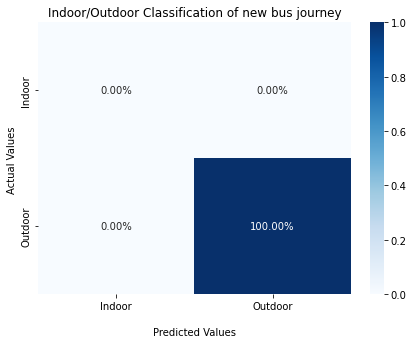

In [147]:


fig = plt.figure(figsize = (7,5))
ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('Indoor/Outdoor Classification of new bus journey');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Indoor','Outdoor'])
ax.yaxis.set_ticklabels(['Indoor','Outdoor'])

## Display the visualization of the Confusion Matrix.
plt.show()


In [97]:
indoor_outdoor_classified_data2['timestamp'] = pd.to_datetime(indoor_outdoor_classified_data2['timestamp'], errors='coerce')

In [98]:
transport_classified_data2 = classify_transportation_airspeck_data(data= indoor_outdoor_classified_data2,model =transport_model)

Running time: 78.23408699999982 Seconds


In [99]:
np.unique(transport_classified_data2['mode'],return_counts =True)

(array(['In the car', 'On the bus', 'On the train', 'Riding a bike',
        'Walking/running'], dtype=object),
 array([   6, 1256,  148,   15,  191]))

In [154]:
cf_matrix = ([[ 0,0,0,0,0],[ 6, 1256,  148,   15,  191],[ 0,0,0,0,0],[ 0,0,0,0,0],[ 0,0,0,0,0]])

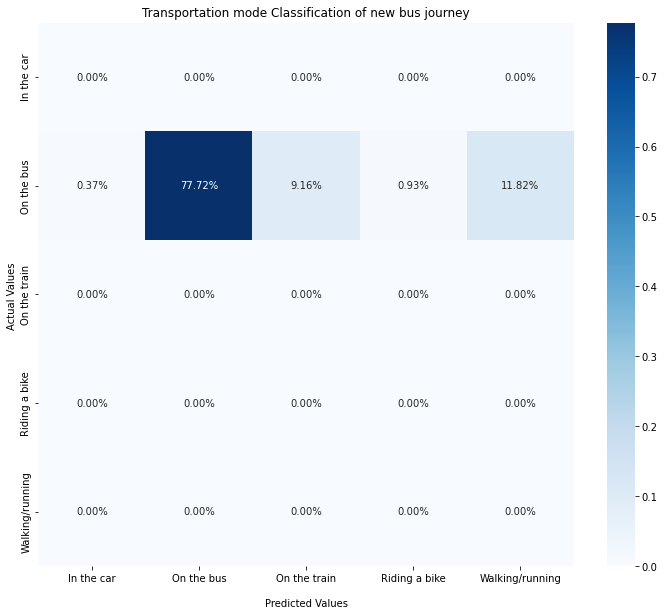

In [155]:

fig = plt.figure(figsize = (12,10))
ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('Transportation mode Classification of new bus journey');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['In the car', 'On the bus', 'On the train', 'Riding a bike',
        'Walking/running'])
ax.yaxis.set_ticklabels(['In the car', 'On the bus', 'On the train', 'Riding a bike',
        'Walking/running'])

## Display the visualization of the Confusion Matrix.
plt.show()



## tube journey

In [101]:
tube_jour = new_logs.loc[new_logs['activity'] == 'On the tube']

In [102]:
indoor_outdoor_classified_data3 = classify_in_out_airspeck_data(data = tube_jour, model= in_out_loaded_model)

bbbbb
Running time: 331.42736800000057 Seconds


In [103]:
np.unique(indoor_outdoor_classified_data3['i/o'],return_counts =True)

(array([0, 1]), array([ 15, 513]))

In [141]:
indoor_outdoor_classified_data3['location'] = 1

In [144]:
cf_matrix = ([[  0,   0],
       [ 0, 100]])

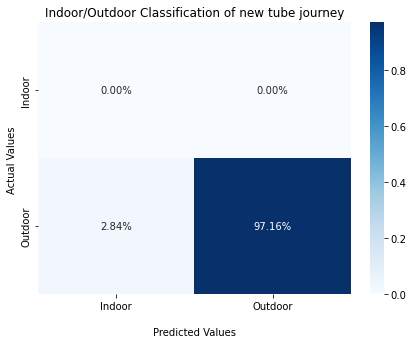

In [145]:
cf_matrix = confusion_matrix(indoor_outdoor_classified_data3['location'],indoor_outdoor_classified_data3['i/o'])


fig = plt.figure(figsize = (7,5))
ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('Indoor/Outdoor Classification of new tube journey');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Indoor','Outdoor'])
ax.yaxis.set_ticklabels(['Indoor','Outdoor'])

## Display the visualization of the Confusion Matrix.
plt.show()



In [104]:
indoor_outdoor_classified_data3['timestamp'] = pd.to_datetime(indoor_outdoor_classified_data3['timestamp'], errors='coerce')

In [105]:
transport_classified_data3 = classify_transportation_airspeck_data(data= indoor_outdoor_classified_data3,model =transport_model)

Running time: 62.29997800000001 Seconds


In [148]:
np.unique(transport_classified_data3['mode'],return_counts =True)

(array(['In the car', 'On the bus', 'On the train', 'On the tube',
        'Riding a bike', 'Walking/running'], dtype=object),
 array([  8, 240,  18,   6, 152,  85]))

In [107]:
import get_Mode as gm
import draw_map_xd as dm

In [108]:
c = gm.getCoords(transport_classified_data3)
gm.getMode(c,transport_classified_data3,'mode',classification = True)

## Test your implementation

This is a complete function which loads the data and the model, applies the model on the data and returns a DataFrame with timestamps as the index, one column of probabilities for each class and one column denoting the final class.

In [19]:
def apply_classifier(data_path: str, subject_id: str, in_out_model_path: str,transport_model_path: str):
    # Load your model
    in_out_model = load_model(in_out_model_path)
    transport_model = load_model(transport_model_path)
    
    #################
    # DO NOT MODIFY #
    #################
    # This is just loading the data and shaping it into a common format
    
    data = pd.read_csv(data_path)
    data.timestamp = pd.to_datetime(data.timestamp)
    data.index = data.timestamp

    
    # TODO your functions here
    start = time.clock()
    print("*"*80)
    print("Classifying in/out airspeck data")
    print("*"*80)
    Required_columns_io = ['timestamp','pm1','pm2_5','pm10','gpsLongitude','gpsLatitude','gpsAltitude','i/o']
    in_out_classified_data = classify_in_out_airspeck_data(data=data, model=in_out_model,subject_id=subject_id)
    
    print("*"*80)
    print("In_Out Classification done!")
    print("*"*80)

    print("*"*80)
    print("Classifying transportation airspeck data")
    print("*"*80)
    
    transport_classified_data = classify_transportation_airspeck_data(data= in_out_classified_data,model =transport_model)
    Required_columns_trans = ['timestamp','pm1','pm2_5','pm10','gpsLongitude','gpsLatitude','gpsAltitude','mode']

    print("*"*80)
    print("Transportation mode Classification done!")
    print("*"*80)
    end = time.clock()
    print('Running time: %s Seconds' % (end - start))
    # This needs to be returned in the specified format, return two dataframe
    return in_out_classified_data[Required_columns_io], transport_classified_data[Required_columns_trans]

In [22]:
data_path = "./data/in_out/asthma_raw/INH007(1)_airspeck_personal_manual_raw.csv"
in_out_model_path = "./models/xudong/example_model/in_out_classification_model.sav"
trans_mode_model_path = './models/xudong/example_model/transportation_mode_classification_model.sav'

in_out_classified_data, transport_classified_data = apply_classifier(data_path=data_path, subject_id='INH007(1)', in_out_model_path=in_out_model_path,transport_model_path=trans_mode_model_path)

********************************************************************************
Classifying in/out airspeck data
********************************************************************************
Running time: 273.0794920000001 Seconds
********************************************************************************
In_Out Classification done!
********************************************************************************
********************************************************************************
Classifying transportation airspeck data
********************************************************************************
Running time: 311.86752 Seconds
********************************************************************************
Transportation mode Classification done!
********************************************************************************
Running time: 587.4301770000002 Seconds


In [24]:
in_out_classified_data

,timestamp,pm1,pm2_5,pm10,gpsLongitude,gpsLatitude,gpsAltitude,i/o
2022-01-13 18:44:48.372,2022-01-13 18:44:48.372,0.000000,0.000000,0.000000,-0.210217,51.495004,51.800003,0
2022-01-13 18:45:14.814,2022-01-13 18:45:14.814,17.519646,37.952890,121.080780,-0.210217,51.495007,51.900002,0
2022-01-13 18:45:44.459,2022-01-13 18:45:44.459,11.856957,25.740059,74.875020,-0.210217,51.495007,51.900002,0
2022-01-13 18:46:15.413,2022-01-13 18:46:15.413,8.303588,17.407263,31.142834,-0.210217,51.495007,61.600002,0
2022-01-13 18:46:45.104,2022-01-13 18:46:45.104,6.622044,13.094225,42.310710,-0.210217,51.495007,58.300003,0
...,...,...,...,...,...,...,...,...
2022-01-28 06:40:55.455,2022-01-28 06:40:55.455,0.016335,0.017400,0.017400,-0.171907,51.490907,56.500000,1
2022-01-28 06:41:34.794,2022-01-28 06:41:34.794,0.011367,0.015076,0.015163,-0.171932,51.490907,56.500000,1
2022-01-28 06:42:13.495,2022-01-28 06:42:13.495,0.011322,0.012060,0.012060,-0.172038,51.490922,56.500000,1
2022-01-28 06:42:52.193,2022-01-28 06:42:52.193,0.001606,0.001710,0.001710,-0.171966,51.490913,56.500000,1


In [25]:
transport_classified_data

,timestamp,pm1,pm2_5,pm10,gpsLongitude,gpsLatitude,gpsAltitude,mode
2022-01-13 18:44:48.372,2022-01-13 18:44:48.372,0.000000,0.000000,0.000000,-0.210217,51.495004,51.800003,On the train
2022-01-13 18:45:14.814,2022-01-13 18:45:14.814,17.519646,37.952890,121.080780,-0.210217,51.495007,51.900002,On the bus
2022-01-13 18:45:44.459,2022-01-13 18:45:44.459,11.856957,25.740059,74.875020,-0.210217,51.495007,51.900002,On the train
2022-01-13 18:46:15.413,2022-01-13 18:46:15.413,8.303588,17.407263,31.142834,-0.210217,51.495007,61.600002,On the train
2022-01-13 18:46:45.104,2022-01-13 18:46:45.104,6.622044,13.094225,42.310710,-0.210217,51.495007,58.300003,On the train
...,...,...,...,...,...,...,...,...
2022-01-28 06:30:46.568,2022-01-28 06:30:46.568,0.027558,0.037090,0.037316,-0.182480,51.485112,54.900002,On the train
2022-01-28 06:31:18.187,2022-01-28 06:31:18.187,0.010059,0.010715,0.010715,-0.180780,51.486118,54.800003,Riding a bike
2022-01-28 06:31:50.413,2022-01-28 06:31:50.413,0.013930,0.014839,0.014839,-0.179365,51.486995,54.400002,On the train
2022-01-28 06:32:22.035,2022-01-28 06:32:22.035,0.018072,0.019251,0.019251,-0.177246,51.488329,54.400002,On the train
